<a href="https://colab.research.google.com/github/JuanPabl07DP/CatsVsDogsRGB/blob/main/Copia_de_CatsVsDogs_RGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from platform import python_version
'Python ' + python_version()
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
#Importación de dataset
datos, metadatos = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)
metadatos

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteAL3D5L/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmpbxi30civtfds'),
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    

In [ ]:
import os
import shutil
# Definir rutas
base_dir = 'cats_vs_dogs'
train_dir = os.path.join(base_dir, 'train')
dev_dir = os.path.join(base_dir, 'dev')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(dev_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Crear subdirectorios para gatos y perros
for category in ['cat', 'dog']:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(dev_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# Dividir el dataset en train, dev y test
def save_images(dataset, subset_dir):
    for i, (image, label) in enumerate(dataset):
        label = 'cat' if label == 0 else 'dog'
        file_path = os.path.join(subset_dir, label, f'{label}.{i}.jpg')
        tf.keras.preprocessing.image.save_img(file_path, image)

# Definir las proporciones para cada conjunto
num_examples = metadatos.splits['train'].num_examples
train_size = int(0.8 * num_examples)
dev_size = int(0.1 * num_examples)
test_size = num_examples - train_size - dev_size

# Crear los datasets
full_dataset = datos['train']
train_dataset = full_dataset.take(train_size)
remaining = full_dataset.skip(train_size)
dev_dataset = remaining.take(dev_size)
test_dataset = remaining.skip(dev_size)

# Guardar las imágenes en los directorios correspondientes
save_images(train_dataset, train_dir)
save_images(dev_dataset, dev_dir)
save_images(test_dataset, test_dir)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Variables for pre-processing.
tamañoimg = 250
batch = 64


train_datagen = ImageDataGenerator(rescale=1.0/255)
dev_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Cargar las imágenes desde los directorios con augmentación para entrenamiento y solo reescalado para validación y prueba
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(tamañoimg, tamañoimg),
    color_mode='rgb',
    batch_size=batch,
    class_mode='binary'           # Tipo de clasificación (binaria en este caso)
)

dev_generator = dev_datagen.flow_from_directory(
    dev_dir,
    target_size=(tamañoimg, tamañoimg),
    color_mode='rgb',
    batch_size=batch,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(tamañoimg, tamañoimg),
    color_mode='rgb',
    batch_size=batch,
    class_mode='binary'
)

Found 18609 images belonging to 2 classes.
Found 2326 images belonging to 2 classes.
Found 2327 images belonging to 2 classes.


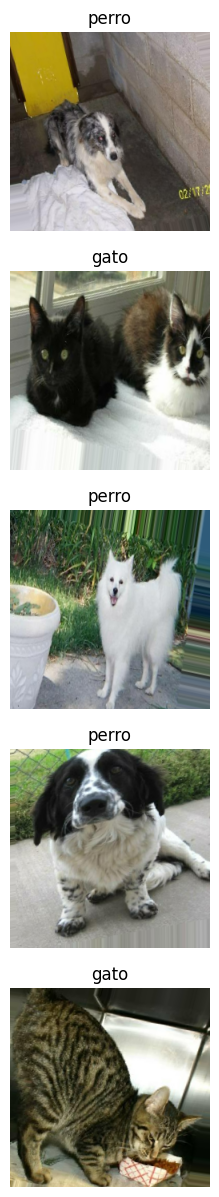

In [ ]:
import matplotlib.pyplot as plt

def plotImages(images_arr, labels):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))
    axes = axes.flatten()

    # 1 is for dog and 0 is for cat
    categorias = {1: 'perro', 0: 'gato'}

    for img, label, ax in zip(images_arr, labels, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(categorias[label])

    plt.show()

# Ejemplo de uso con un generador de datos
sample_training_images, sample_training_labels = next(train_generator)

plotImages(sample_training_images[:5], sample_training_labels[:5])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
gc.collect()
parameters = {'eval_batch_size': 32,
              'epochs': 6,
              'dropout': 0.0,
              'optimizer': 'Adam',
              'loss': 'binary_crossentropy',
              'activation':'sigmoid'}

def dogCatCNN(train_generator, dev_generator, params):
    model = Sequential(name="dog_cat_CNN")
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(tamañoimg, tamañoimg, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(28, activation='relu'))
    model.add(Dense(1, activation=params['activation']))
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['accuracy'])
    print(model.summary())
    model.fit(train_generator,
              steps_per_epoch=train_generator.samples // train_generator.batch_size,
              validation_data=dev_generator,
              validation_steps=dev_generator.samples // dev_generator.batch_size,
              epochs=params['epochs'])
    return model

dog_cat_CNN = dogCatCNN(train_generator, dev_generator, parameters)

157

Model: "dog_cat_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 124, 124, 32)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 492032)            0         
                                                                 
 dense_2 (Dense)             (None, 28)                13776924  
                                                                 
 dense_3 (Dense)             (None, 1)                 29        
                                                                 
Total params: 13777849 (52.56 MB)
Trainable params: 13777849 (52.56 MB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
gc.collect()
parameters = {'eval_batch_size': 32,
              'epochs': 6,
              'dropout': 0.6,
              'optimizer': 'Adam',
              'loss': 'binary_crossentropy',
              'activation':'sigmoid'}

def dogCatCNN(train_generator, dev_generator, params):
    model = Sequential(name="dog_cat_CNN")
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(tamañoimg, tamañoimg, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dropout(params['dropout']))
    model.add(Dense(28, activation='relu'))
    model.add(Dense(1, activation=params['activation']))
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['accuracy'])
    print(model.summary())
    model.fit(train_generator,
              steps_per_epoch=train_generator.samples // train_generator.batch_size,
              validation_data=dev_generator,
              validation_steps=dev_generator.samples // dev_generator.batch_size,
              epochs=params['epochs'])
    return model

dog_cat_CNN = dogCatCNN(train_generator, dev_generator, parameters)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
gc.collect()
parameters = {'eval_batch_size': 32,
              'batch_size': 32,
              'epochs': 15,
              'dropout': 0.4,
              'optimizer': 'Adam',
              'loss': 'binary_crossentropy',
              'activation':'sigmoid'}

def dogCatCNN(train_generator, dev_generator, params):
    model = Sequential(name="dog_cat_CNN")
    model.add(Conv2D(filters=16, kernel_size=(2,2), activation='relu', input_shape=(tamañoimg, tamañoimg, 3)))
    model.add(MaxPooling2D(4, 4))
    model.add(Conv2D(filters=32, kernel_size=(2,2), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dropout(params['dropout']))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation=params['activation']))
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['accuracy'])
    print(model.summary())
    model.fit(train_generator,
              steps_per_epoch=train_generator.samples // train_generator.batch_size,
              validation_data=dev_generator,
              validation_steps=dev_generator.samples // dev_generator.batch_size,
              epochs=params['epochs'])
    return model

dog_cat_CNN = dogCatCNN(train_generator, dev_generator, parameters)

106

Model: "dog_cat_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 249, 249, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
gc.collect()
parameters = {'eval_batch_size': 32,
              'batch_size': 32,
              'epochs': 15,
              'dropout': 0.6,
              'optimizer': 'Adam',
              'loss': 'binary_crossentropy',
              'activation':'sigmoid'}

def dogCatCNN(train_generator, dev_generator, params):
    model = Sequential(name="dog_cat_CNN")
    model.add(Conv2D(filters=16, kernel_size=(2,2), activation='relu', input_shape=(tamañoimg, tamañoimg, 3)))
    model.add(MaxPooling2D(4, 4))
    model.add(Conv2D(filters=32, kernel_size=(2,2), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dropout(params['dropout']))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation=params['activation']))
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['accuracy'])
    print(model.summary())
    model.fit(train_generator,
              steps_per_epoch=train_generator.samples // train_generator.batch_size,
              validation_data=dev_generator,
              validation_steps=dev_generator.samples // dev_generator.batch_size,
              epochs=params['epochs'])
    return model

dog_cat_CNN = dogCatCNN(train_generator, dev_generator, parameters)

2131

Model: "dog_cat_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 249, 249, 16)      208       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 62, 62, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 61, 61, 32)        2080      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 14, 14, 64)        

In [ ]:
dog_cat_CNN.evaluate(test_generator)

37/37 [==============================] - 7s 182ms/step - loss: 0.2798 - accuracy: 0.8913


[0.27983349561691284, 0.8912762999534607]

1/1 [==============================] - 0s 54ms/step


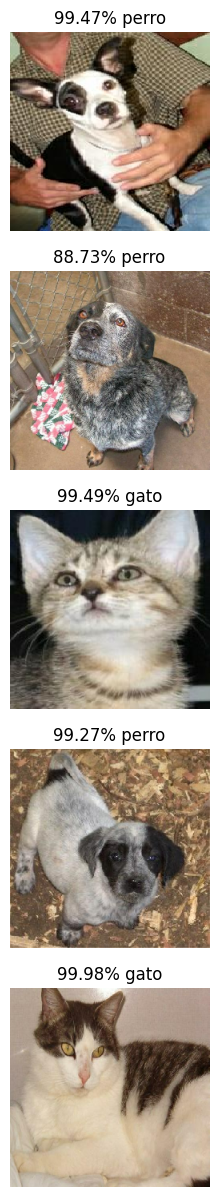

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plotImages(images_arr, probabilities=None):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))
    axes = axes.flatten()

    if probabilities is None:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            probability_scalar = probability.item()
            if probability_scalar > 0.5:
                ax.set_title("%.2f" % (probability_scalar * 100) + "% perro")
            else:
                ax.set_title("%.2f" % ((1 - probability_scalar) * 100) + "% gato")

    plt.show()

# Ejemplo de uso con un generador de datos
sample_training_images, _ = next(train_generator)
probabilities = dog_cat_CNN.predict(sample_training_images[:5])

plotImages(sample_training_images[:5], probabilities)


1/1 [==============================] - 0s 93ms/step


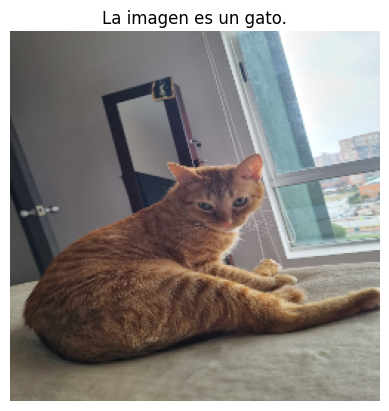

In [ ]:
import cv2
import matplotlib.pyplot as plt

def ask(model, image_path):
    # Leer la imagen
    image = cv2.imread(image_path)

    # Redimensionar la imagen
    image = cv2.resize(image, (tamañoimg, tamañoimg))

    # Ajustar el tamaño de la imagen para que coincida con el formato de entrada del modelo
    image_input = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_input = image_input.reshape(1, tamañoimg, tamañoimg, 3)

    # Realizar la predicción
    predictions = model.predict(image_input)

    # Convertir las probabilidades en etiquetas (0 o 1) si es un problema de clasificación binaria
    predicted_label = 1 if predictions[0][0] > 0.5 else 0

    # Imprimir la etiqueta predicha
    if predicted_label == 1:
        plt.title("La imagen es un perro.")
    else:
        plt.title("La imagen es un gato.")

    # Mostrar la imagen procesada
    plt.imshow(image_input[0])
    plt.axis('off')
    plt.show()

# Uso de la función
ask(dog_cat_CNN, '/content/gatopapula1.jfif')

# **Aumento de datos**

In [ ]:
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,            # Rotación de la imagen en un rango de 15 grados
    width_shift_range=0.1,        # Desplazamiento horizontal de la imagen en un rango de 10%
    height_shift_range=0.1,       # Desplazamiento vertical de la imagen en un rango de 10%
    shear_range=10,               # Aplicar transformación de corte en un rango de 10 grados
    zoom_range=0.1,               # Aplicar zoom dentro de un rango de 10%
    horizontal_flip=True,         # Voltear horizontalmente la imagen
    vertical_flip=False,          # No voltear verticalmente la imagen
    fill_mode='nearest'           # Modo de relleno para los píxeles fuera de los límites
)
# Cargar las imágenes desde los directorios con augmentación para entrenamiento y solo reescalado para validación y prueba
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(tamañoimg, tamañoimg),
    color_mode='rgb',
    batch_size=batch,
    class_mode='binary'           # Tipo de clasificación (binaria en este caso)
)
# training the model
dog_cat_CNN = dogCatCNN(train_generator, dev_generator, parameters)

Found 18609 images belonging to 2 classes.
Model: "dog_cat_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 249, 249, 16)      208       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 32)        2080      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling

In [ ]:
dog_cat_CNN.evaluate(test_generator)

37/37 [==============================] - 7s 183ms/step - loss: 0.2405 - accuracy: 0.9003


[0.24053139984607697, 0.9003008008003235]

1/1 [==============================] - 0s 314ms/step


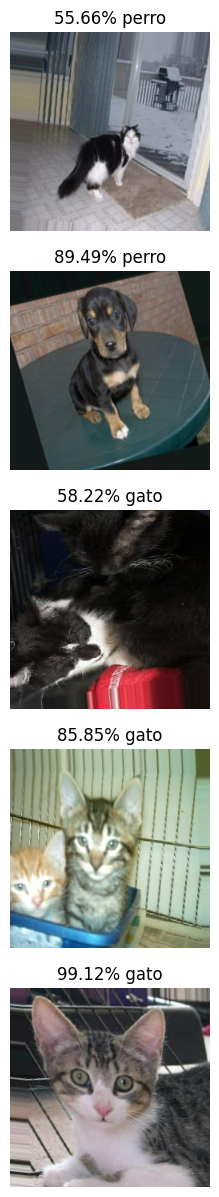

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plotImages(images_arr, probabilities=None):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))
    axes = axes.flatten()

    if probabilities is None:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            probability_scalar = probability.item()
            if probability_scalar > 0.5:
                ax.set_title("%.2f" % (probability_scalar * 100) + "% perro")
            else:
                ax.set_title("%.2f" % ((1 - probability_scalar) * 100) + "% gato")

    plt.show()

# Ejemplo de uso con un generador de datos
sample_training_images, _ = next(train_generator)
probabilities = dog_cat_CNN.predict(sample_training_images[:5])

plotImages(sample_training_images[:5], probabilities)


1/1 [==============================] - 0s 25ms/step


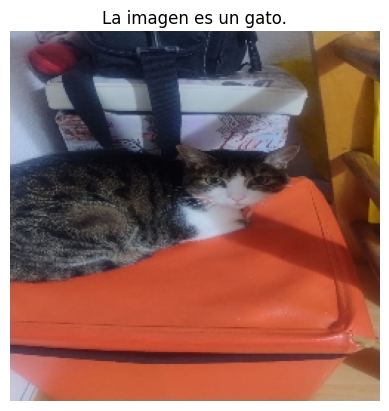

In [ ]:
import cv2
import matplotlib.pyplot as plt

def ask(model, image_path):
    # Leer la imagen
    image = cv2.imread(image_path)

    # Redimensionar la imagen
    image = cv2.resize(image, (tamañoimg, tamañoimg))

    # Ajustar el tamaño de la imagen para que coincida con el formato de entrada del modelo
    image_input = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_input = image_input.reshape(1, tamañoimg, tamañoimg, 3)

    # Realizar la predicción
    predictions = model.predict(image_input)

    # Convertir las probabilidades en etiquetas (0 o 1) si es un problema de clasificación binaria
    predicted_label = 1 if predictions[0][0] > 0.5 else 0

    # Imprimir la etiqueta predicha
    if predicted_label == 1:
        plt.title("La imagen es un perro.")
    else:
        plt.title("La imagen es un gato.")

    # Mostrar la imagen procesada
    plt.imshow(image_input[0])
    plt.axis('off')
    plt.show()

# Uso de la función
ask(dog_cat_CNN, '/content/4c491df6-5526-4488-ab65-21febdf022c9.jfif')